<a href="https://colab.research.google.com/github/Sofismarilla/PatientVisitsForecasting/blob/main/VAR_Patient_Visits_Forecasting_for_Allocation_Decision_of_Healthcare_%5BGroupTestA%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multivariate Time Series Forecasting using VAR Model based on Patient Visits Medical Laboratory Data (Group Test A)**

## **Step#0 Fire System**

In [1]:
!pip install pmdarima
!pip install shap
!pip install --upgrade mxnet~=1.7 gluonts
!pip install python-utils
!pip install plotly==4.1.0
!pip install -U scikit-learn
!pip install statsmodels
!pip install --user scipy==1.2.0
!pip install -U statsmodels

     |████████████████████████████████| 1.5MB 5.4MB/s 
     |████████████████████████████████| 9.5MB 15.9MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 358kB 5.0MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491641 sha256=3909a2fafe8ad86e59dabe798f71f03b37a8e84c4e73f2ec075cdd894f28e0d5
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
     |████████████████████████████████| 46.9MB 66kB/s 
     |████████████████████████████████| 901kB 42.5MB/s 
     |████████████████████████████████| 10.1MB 28.3MB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 7.1MB 5.4MB/s 
ERROR: cufflinks 0.17.3 has requirement plotly>=4.1.1, b

In [2]:
import warnings
import numpy as np
import pandas as pd

# Data visualization
import folium
import datetime
%matplotlib inline
import seaborn as sns 
import matplotlib as mpl
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.ticker as tkr
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from IPython.display import display, HTML, display_html

# Method Requirement
import keras
import sklearn
import tensorflow as tf
from keras.layers import *
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Statistics 
import scipy
from math import sqrt
from time import time
from scipy import stats
import statsmodels as sms
from timeit import default_timer as timer
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_style('white')
warnings.filterwarnings('ignore')
plt.rcParams['axes.grid'] = False
sns.set_context("paper", font_scale=1.3)
plt.rcParams['figure.figsize'] = (10, 8)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

## **Step#1 Input Data**

In [28]:
data = pd.read_csv('/content/drive/MyDrive/THESIS/Dataset/dateset_patient.csv')

In [29]:
data.head()

,date,hm,hm_aw,hm_am,cc,cc_aw,cc_am,day_week
0,7/1/2017,66,48,63,44,37,45,6
1,7/2/2017,53,53,62,72,37,43,7
2,7/3/2017,74,54,59,87,42,44,1
3,7/4/2017,87,56,57,58,49,44,2
4,7/5/2017,95,62,58,72,53,44,3


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      1348 non-null   object
 1   hm        1348 non-null   int64 
 2   hm_aw     1348 non-null   int64 
 3   hm_am     1348 non-null   int64 
 4   cc        1348 non-null   int64 
 5   cc_aw     1348 non-null   int64 
 6   cc_am     1348 non-null   int64 
 7   day_week  1348 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 84.4+ KB


In [31]:
data['date'] = pd.to_datetime(data['date'], infer_datetime_format=True)
data['weekday']= data.apply(lambda row: row['date'].weekday(),axis=1)
data['weekday'] = (data["weekday"] < 5).astype(int)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1348 non-null   datetime64[ns]
 1   hm        1348 non-null   int64         
 2   hm_aw     1348 non-null   int64         
 3   hm_am     1348 non-null   int64         
 4   cc        1348 non-null   int64         
 5   cc_aw     1348 non-null   int64         
 6   cc_am     1348 non-null   int64         
 7   day_week  1348 non-null   int64         
 8   weekday   1348 non-null   int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 94.9 KB


In [33]:
data.head(5)

,date,hm,hm_aw,hm_am,cc,cc_aw,cc_am,day_week,weekday
0,2017-07-01,66,48,63,44,37,45,6,0
1,2017-07-02,53,53,62,72,37,43,7,0
2,2017-07-03,74,54,59,87,42,44,1,1
3,2017-07-04,87,56,57,58,49,44,2,1
4,2017-07-05,95,62,58,72,53,44,3,1


## **Step#2 Data Processing**

### **Picking Variable**

In [23]:
df = data.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0)

In [34]:
hm = df['hm'].fillna(df['hm'].mean())
hm_aw = df['hm_aw'].fillna(df['hm'].mean())
hm_am = df['hm_am'].fillna(df['hm'].mean())
weekday = df['weekday'].fillna(df['hm'].mean())

In [35]:
df_hm = pd.DataFrame({'hm':hm, 'hm_aw':hm_aw, 'hm_am':hm_am, 'weekday':weekday})
df.to_csv("hm.csv")
df_hm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   hm       1348 non-null   int64
 1   hm_aw    1348 non-null   int64
 2   hm_am    1348 non-null   int64
 3   weekday  1348 non-null   int64
dtypes: int64(4)
memory usage: 42.2 KB


In [36]:
df_hm.head(5)

,hm,hm_aw,hm_am,weekday
0,66,48,63,0
1,53,53,62,0
2,74,54,59,1
3,87,56,57,1
4,95,62,58,1


### **Stationary Test**

In [42]:
#creating test for stationarity
from statsmodels.tsa.stattools import adfuller
def test_stationary(timeseries):

  #Perform Dicky Fuller Test:
  print ('Result of Dicky-Fuller Test:')
  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], 
                       index=['Test Statistic','p-value','#Lags Used',
                              'Number of Observations Used'])
  
  for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)

In [48]:
#Loop to check all columns of the DF
import functools
df_hm.apply(functools.partial(test_stationary))

Result of Dicky-Fuller Test:
Test Statistic                  -2.5335
p-value                          0.1075
#Lags Used                      20.0000
Number of Observations Used   1327.0000
Critical Value (1%)             -3.4353
Critical Value (5%)             -2.8637
Critical Value (10%)            -2.5679
dtype: float64
Result of Dicky-Fuller Test:
Test Statistic                  -2.7086
p-value                          0.0726
#Lags Used                      23.0000
Number of Observations Used   1324.0000
Critical Value (1%)             -3.4353
Critical Value (5%)             -2.8637
Critical Value (10%)            -2.5679
dtype: float64
Result of Dicky-Fuller Test:
Test Statistic                  -2.8019
p-value                          0.0580
#Lags Used                      23.0000
Number of Observations Used   1324.0000
Critical Value (1%)             -3.4353
Critical Value (5%)             -2.8637
Critical Value (10%)            -2.5679
dtype: float64
Result of Dicky-Fuller Test:

hm         None
hm_aw      None
hm_am      None
weekday    None
dtype: object

### **Differencing**

In [49]:
df_diff = df_hm.diff().dropna()
df_diff = df_diff.astype(int)
df_diff.head()

,hm,hm_aw,hm_am,weekday
1,-13,5,-1,0
2,21,1,-3,1
3,13,2,-2,0
4,8,6,1,0
5,-1,6,0,0


In [50]:
df_diff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1347 entries, 1 to 1347
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   hm       1347 non-null   int64
 1   hm_aw    1347 non-null   int64
 2   hm_am    1347 non-null   int64
 3   weekday  1347 non-null   int64
dtypes: int64(4)
memory usage: 52.6 KB


### **Model Order Selection**

In [51]:
#Creating the VAR model
from statsmodels.tsa.vector_ar.var_model import VAR
model = VAR(df_diff)

In [52]:
#Bestmodel order
modsel = model.select_order(15)
modsel.summary()

,AIC,BIC,FPE,HQIC
0,6.014,6.030,409.1,6.020
1,5.114,5.192,166.4,5.143
2,4.231,4.371,68.79,4.284
3,3.916,4.119,50.21,3.992
4,3.592,3.858,36.32,3.692
5,2.563,2.890,12.97,2.685
6,-59.94,-59.55,9.341e-27,-59.79
7,-66.21,-65.76,1.763e-29,-66.04
8,-67.14,-66.63,6.916e-30,-66.95
9,-67.37*,-66.79*,5.515e-30*,-67.15*


In [53]:
#Automated model order selection
results = model.fit(maxlags=15, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 21, Jun, 2021
Time:                     04:11:51
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -64.7772
Nobs:                     1338.00    HQIC:                  -65.1368
Log likelihood:           36274.5    FPE:                4.14870e-29
AIC:                     -65.3522    Det(Omega_mle):     3.71985e-29
--------------------------------------------------------------------
Results for equation hm
                coefficient        std. error           t-stat            prob
------------------------------------------------------------------------------
const             -0.105599          0.357635           -0.295           0.768
L1.hm             -0.746128          0.027723          -26.914           0.000
L1.hm_aw           0.646553          1.039045            0.622         

### **Splitting Data**

In [54]:
#creating the train and validation set
train = df_diff[:int(0.8*(len(df_diff)))]
test = df_diff[int(0.8*(len(df_diff))):]

In [55]:
train.shape

(1077, 4)

In [56]:
test.shape

(270, 4)

## **Step#3 Fitting and Training Model**

In [58]:
#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit(9)

## **Step#4 Actual vs Prediction Plot and Evaluation Metrics**

In [59]:
# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(test))

In [60]:
prediction.shape

(270, 4)

In [61]:
pd.DataFrame(prediction).head()

,0,1,2,3
0,-7.4202,-3.9154,-0.0135,-1.0000
1,-9.0986,0.9450,-0.5874,0.0000
2,25.1169,-0.6049,-0.3847,1.0000
3,-0.8363,-0.8038,0.5053,0.0000
4,4.2358,-0.4696,0.8434,0.0000


In [62]:
df2 = pd.DataFrame(prediction)[0]
df2.head(30)

0     -7.4202
1     -9.0986
2     25.1169
3     -0.8363
4      4.2358
5     -6.1019
6     -4.4400
7     -7.9129
8    -11.3566
9     27.9884
10    -2.3655
11     3.1440
12    -5.3100
13    -5.2105
14    -7.2976
15   -12.3309
16    29.6895
17    -3.2561
18     4.4468
19    -5.9811
20    -5.7602
21    -6.9345
22   -12.5588
23    30.1391
24    -3.5778
25     4.6779
26    -6.1756
27    -5.8262
28    -6.8065
29   -12.7966
Name: 0, dtype: float64

In [63]:
df.head(1077)

,date,hm,hm_aw,hm_am,cc,cc_aw,cc_am,day_week,weekday
0,2017-07-01,66,48,63,44,37,45,6,0
1,2017-07-02,53,53,62,72,37,43,7,0
2,2017-07-03,74,54,59,87,42,44,1,1
3,2017-07-04,87,56,57,58,49,44,2,1
4,2017-07-05,95,62,58,72,53,44,3,1
...,...,...,...,...,...,...,...,...,...
1072,2020-06-07,39,56,47,57,46,39,7,0
1073,2020-06-08,65,54,48,36,47,40,1,1
1074,2020-06-09,62,58,48,43,45,40,2,1
1075,2020-06-10,48,57,49,44,44,40,3,1


In [64]:
#Convert to original data, 63 from the last train data (hm) values
df_diff_pred = np.cumsum(df2) + 63
pred = pd.DataFrame(df_diff_pred.astype(int))
pred = pred.rename(columns={0:'pred'})
pred.head(30)

,pred
0,55
1,46
2,71
3,70
4,74
5,68
6,64
7,56
8,45
9,73


In [65]:
#Take an original data
actual = np.cumsum(test.hm) + 63
actual = pd.DataFrame(actual)
actual['pred'] = pred['pred'].values
actual.head(30)

,hm,pred
1078,50,55
1079,49,46
1080,94,71
1081,73,70
1082,61,74
1083,85,68
1084,65,64
1085,56,56
1086,55,45
1087,70,73


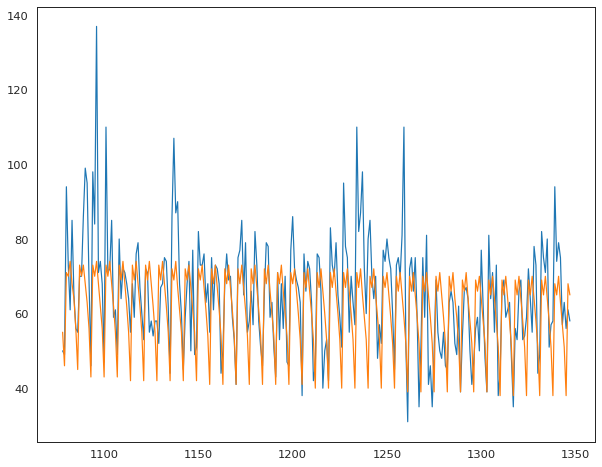

In [66]:
plt.plot(actual['hm'], label='actual')
plt.plot(actual['pred'], label='forecast')

In [67]:
# MSE and RMSE Score
print('MSE value :', mean_squared_error(actual['hm'], actual['pred']))
print('RMSE value  : ', sqrt(mean_squared_error(actual['hm'], actual['pred'])))

MSE value : 152.38518518518518
RMSE value  :  12.344439443943381
